### Source: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [1]:
# Regular
import pandas as pd
import numpy as np
import itertools
import warnings
from pandas import datetime

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

# Statsmosels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
#import pmdarima as pm
from math import sqrt
from pylab import rcParams

plt.style.use('ggplot')

C:\Users\Kristina.popova\AppData\Local\Temp\ipykernel_19420\1497885060.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
all_yrs = pd.read_csv("postpaid_revenues_dataset.csv")
all_yrs['period'] = pd.to_datetime(all_yrs['period'])
#all_yrs = all_yrs.set_index('Period')

#data = all_yrs['total_rev'].values.tolist()
all_yrs.head()

,Total Revenues,period
0,205138133.7,2016-01-31
1,204211508.4,2016-02-28
2,208362844.2,2016-03-31
3,206144224.3,2016-04-30
4,206731476.4,2016-05-31


In [3]:
all_yrs.tail()

,Total Revenues,period
91,316106207.0,2023-08-31
92,318849734.0,2023-09-30
93,317672832.0,2023-10-31
94,316665960.0,2023-11-30
95,315601887.0,2023-12-31


#### Line Plot

<Figure size 1200x500 with 0 Axes>

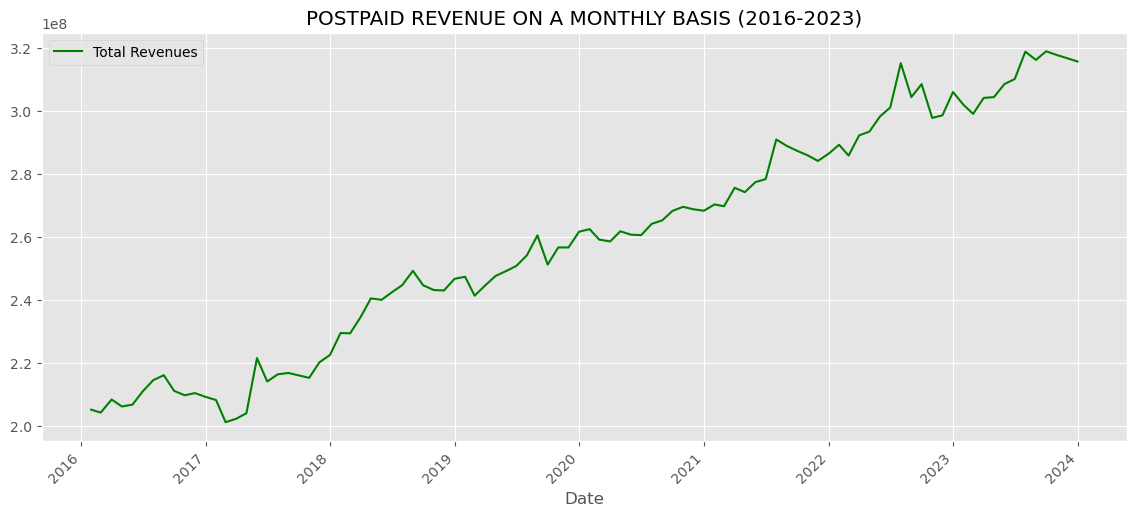

In [4]:
plt.figure(figsize=[12,5])
all_yrs.plot(x='period', y='Total Revenues', figsize=(14,6), legend=True, color='g')
plt.title("POSTPAID REVENUE ON A MONTHLY BASIS (2016-2023)")
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

### Decomposition of the time series

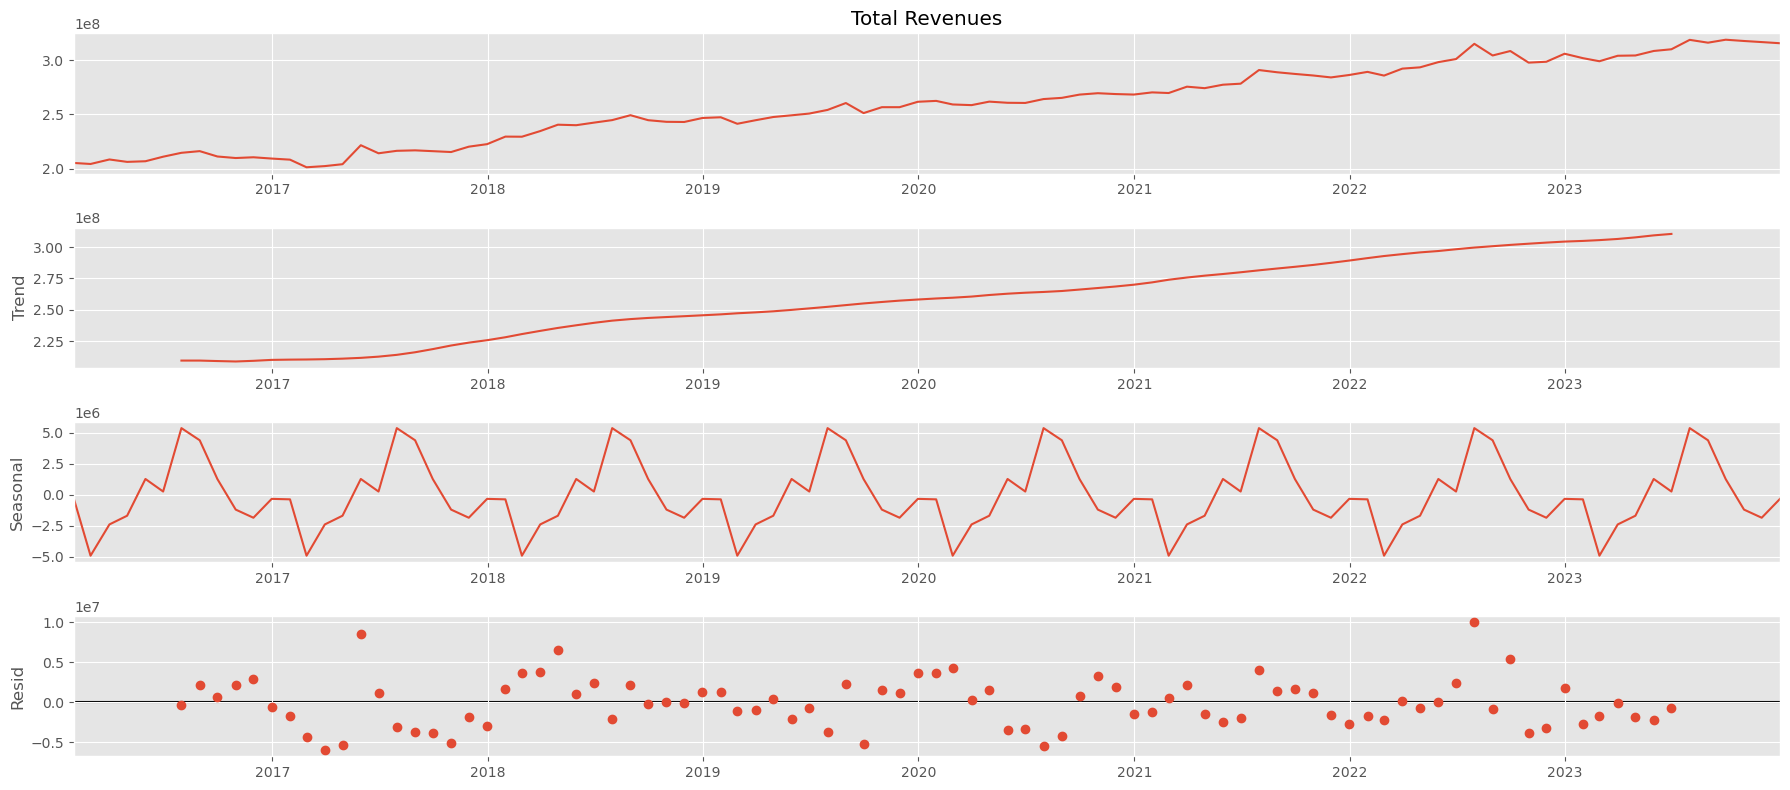

In [5]:
all_yrs = all_yrs.set_index('period')
#all_yrs['period'] = pd.PeriodIndex(all_yrs['period'])
#all_yrs = all_yrs[:-1]
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(all_yrs['Total Revenues'], model='additive', period=12)
fig = decomposition.plot()
plt.show()

#### Stats tests

Automated Dickey Fuller test to check if the series is stationary. If it is not then we need to make it stationary. A stationay time series does not have any season or trend.

In [6]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(all_yrs))

Results of Dickey-Fuller Test:
Test Statistic                 -0.345578
p-value                         0.918796
#Lags Used                      1.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64
None


#### First-order differencing

Results of Dickey-Fuller Test:
Test Statistic                -1.285741e+01
p-value                        5.196432e-24
#Lags Used                     0.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64
None


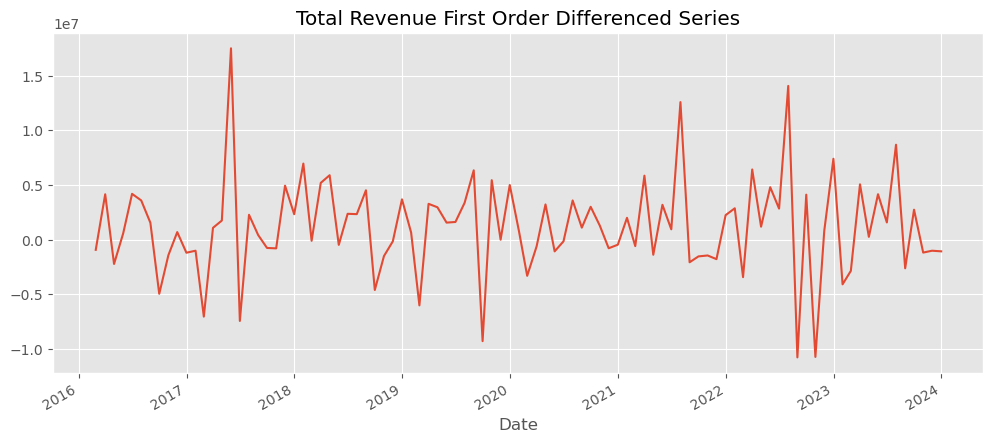

In [7]:
all_yrs['Total Rev. First Difference'] = all_yrs['Total Revenues'] - all_yrs['Total Revenues'].shift(1)
all_yrs.dropna(subset='Total Rev. First Difference', inplace=True)

plt.figure(figsize=[12,5])
all_yrs['Total Rev. First Difference'].plot()
plt.title("Total Revenue First Order Differenced Series")
plt.xlabel("Date")

print(adf_test(all_yrs['Total Rev. First Difference']))

#### Autocorrelation Plots

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

- Autocorrelation before differencing

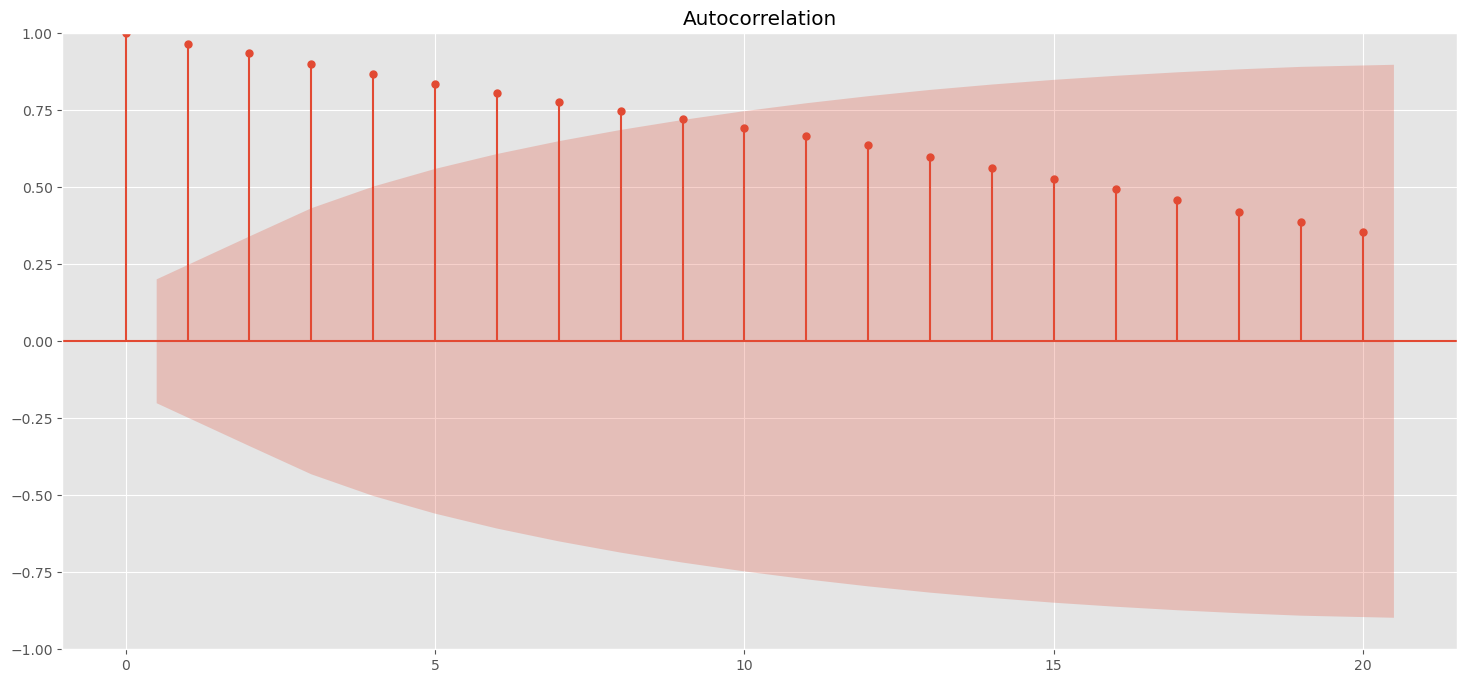

In [8]:
plot_acf(all_yrs['Total Revenues'])
plt.show()

- Autocorrelation after first order differencing

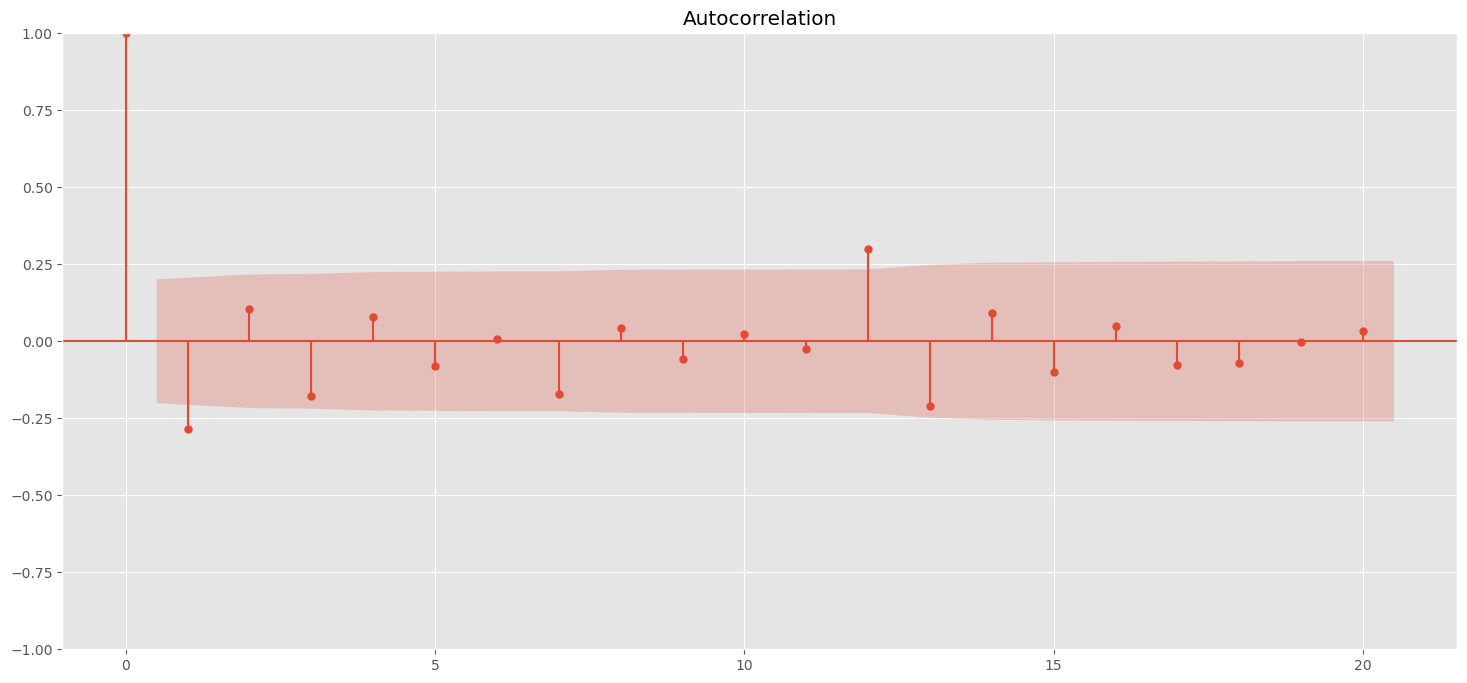

In [9]:
plot_acf(all_yrs['Total Rev. First Difference'].dropna())
plt.show()

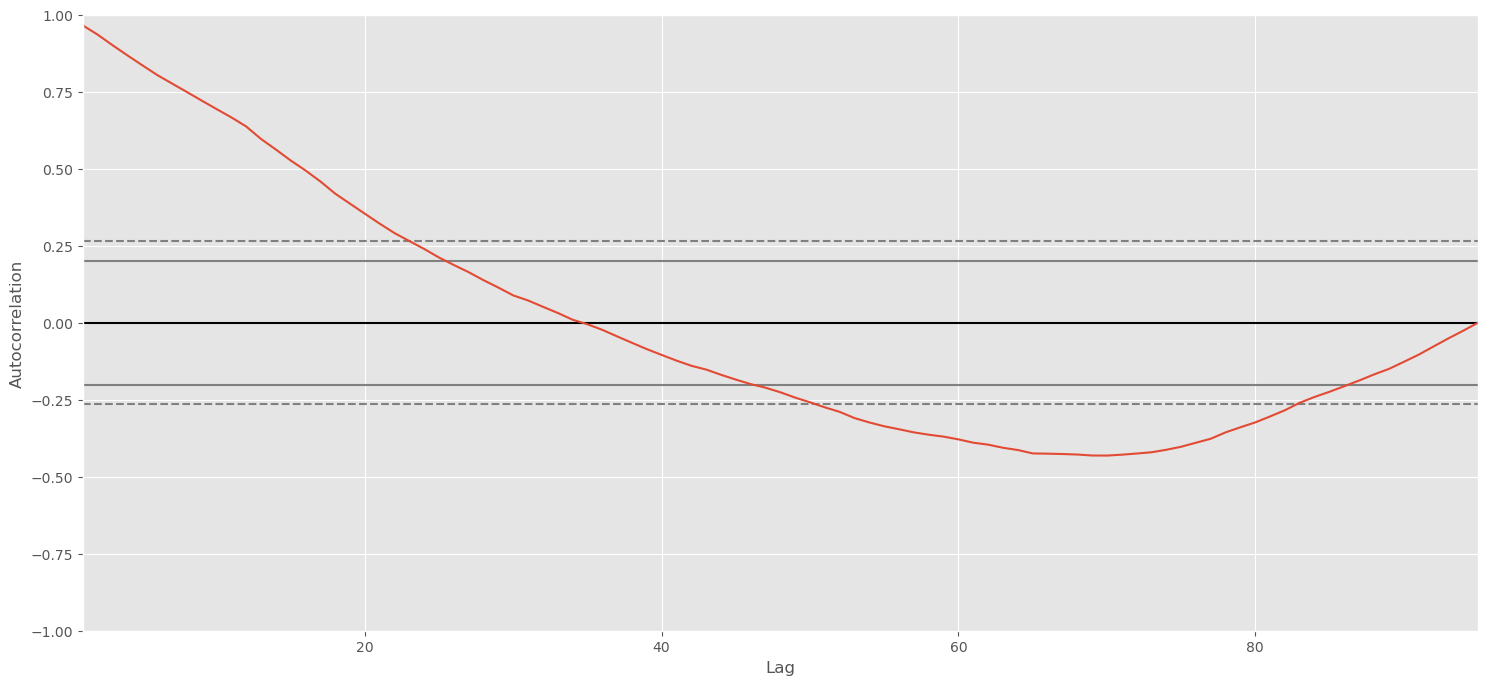

In [10]:
autocorrelation_plot(all_yrs['Total Revenues'])
plt.grid(True)
plt.show()

C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

                                     SARIMAX Results                                      
Dep. Variable:                     Total Revenues   No. Observations:                   95
Model:             SARIMAX(1, 0, 3)x(0, 1, 3, 12)   Log Likelihood               -1400.499
Date:                            Thu, 11 Jan 2024   AIC                           2816.997
Time:                                    14:37:45   BIC                           2836.348
Sample:                                         0   HQIC                          2824.771
                                             - 95                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9974      0.003    363.209      0.000       0.992       1.003
ma.L1         -0.9669      0.064   

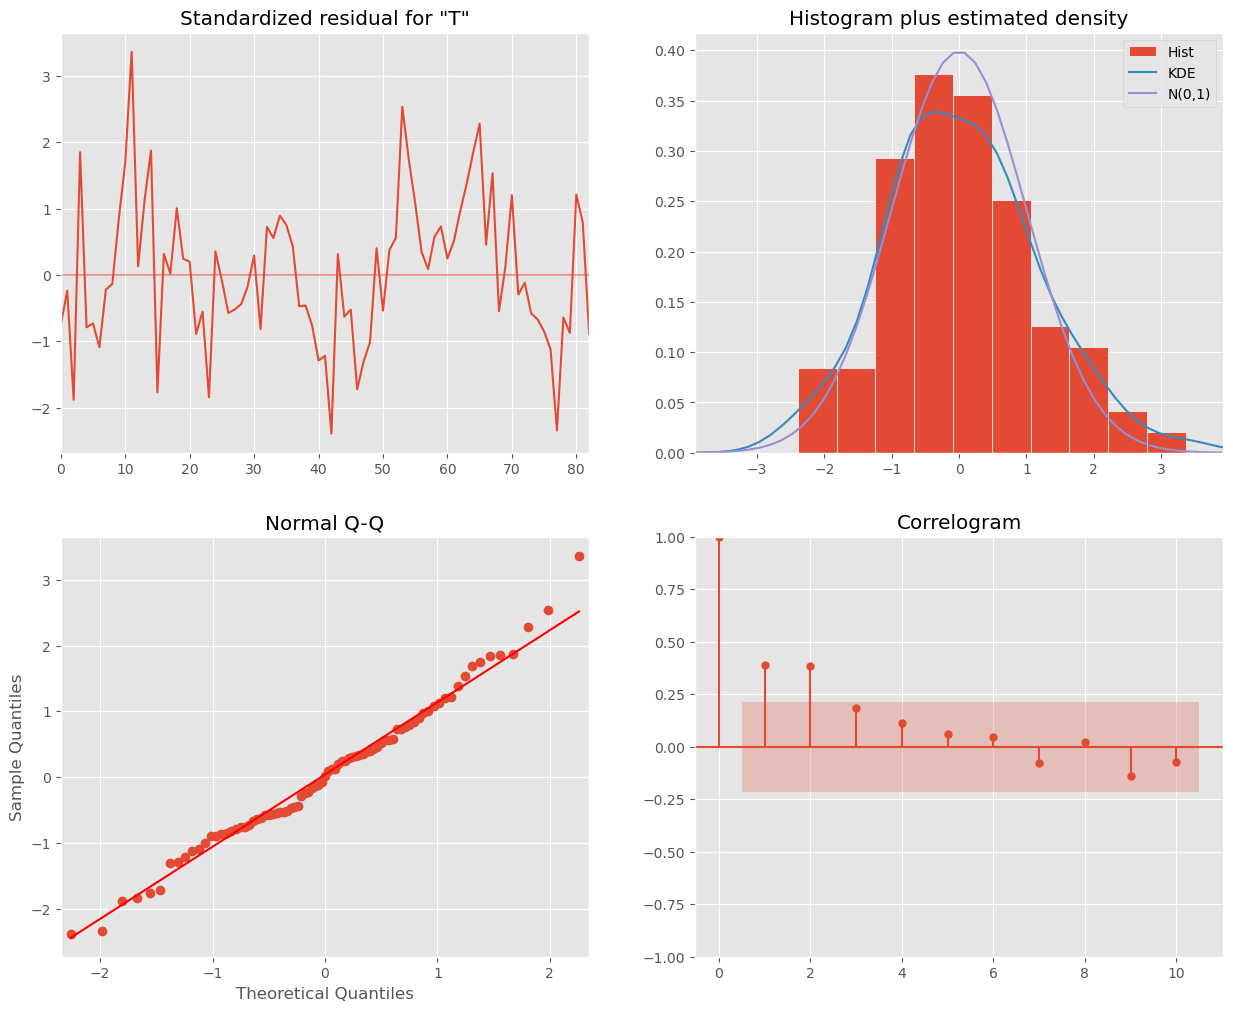

In [30]:
model = SARIMAX(all_yrs['Total Revenues'], order = (1,0,3), seasonal_order = (0,1,3,12))
#model = ARIMA(all_yrs['Total Revenues'])
model_fit = model.fit()
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


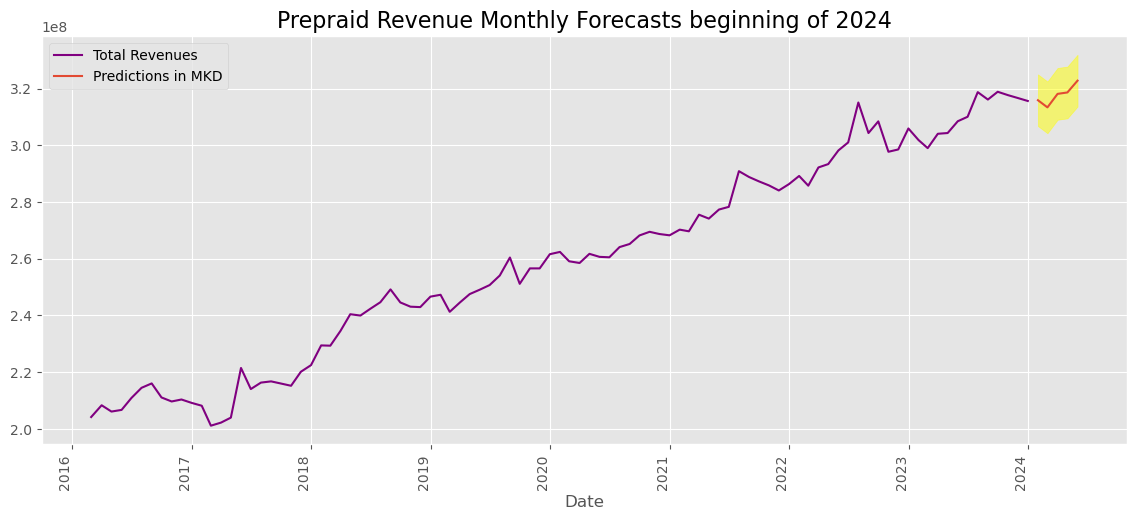

In [31]:
#forecast_index = ['2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31']
forecast_index = ['2024-Jan-31', '2024-Feb-29', '2024-Mar-31', '2024-Apr-30', '2024-May-31']

forecast_values = model_fit.get_forecast(steps=5)
forecast_values_mean = pd.DataFrame()
forecast_values_mean['Predictions in MKD'] = forecast_values.predicted_mean
forecast_values_mean['period'] = pd.to_datetime(forecast_index)
forecast_values_mean = forecast_values_mean.set_index('period')

forecast_ci = forecast_values.conf_int()
forecast_ci = forecast_ci.set_index(pd.to_datetime(forecast_index))

#all_yrs = all_yrs.reset_index()
ax = all_yrs.plot(y='Total Revenues', figsize=(14,6), legend=True, color='purple')

# Plot the forecasted values
forecast_values_mean.plot(ax=ax, label='forecast_rev', figsize=(14,6), grid=True)

# Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='yellow', alpha=.5)

plt.title("Prepraid Revenue Monthly Forecasts beginning of 2024", size=16)
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
ax.axes.get_xaxis().set_visible(True)

plt.show()

In [32]:
forecast_values_mean['Predictions in MKD'].values / 61.5

array([5136140.64720996, 5095124.07614658, 5172486.08079336,
       5180594.39685071, 5248221.84944228])

In [33]:
forecast_values_mean['Predictions in MKD'].values

array([3.15872650e+08, 3.13350131e+08, 3.18107894e+08, 3.18606555e+08,
       3.22765644e+08])

## Model Evaluation

In [25]:
# split into train and test sets
#X = series.values

X = all_yrs['Total Revenues']
size = int(len(X) * 0.85)
train, test = X[:size], X[size:]

model = SARIMAX(train, order = (1,0,3), seasonal_order = (0,1,3,12))
#model = ARIMA(train, order=(3,1,1))
model_fit_last = model.fit()

start = len(train)
end = len(train) + len(test)-1
predictions = model_fit_last.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA predictions')
predictions.index = test.index

evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = np.round(mean_absolute_error(test, predictions), 3)
evaluation_results['mean_squared_error'] = np.round(mean_squared_error(test, predictions), 2)
evaluation_results['root_mean_squared_error'] = np.round(np.sqrt(mean_squared_error(test, predictions)), 3)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions-test)/np.abs(test))*100

C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

In [26]:
test

period
2022-10-31    297705111.1
2022-11-30    298516837.0
2022-12-31    305914774.8
2023-01-31    301834309.0
2023-02-28    298984228.0
2023-03-31    304046143.0
2023-04-30    304305967.0
2023-05-31    308463361.0
2023-06-30    310038943.0
2023-07-31    318721021.0
2023-08-31    316106207.0
2023-09-30    318849734.0
2023-10-31    317672832.0
2023-11-30    316665960.0
2023-12-31    315601887.0
Name: Total Revenues, dtype: float64

In [27]:
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.646532,3670495.288,2.040720e+13,4517432.799,1.181194


In [28]:
for i in range(len(predictions)):
    diff_denar = predictions[i]-test[i]
    diff_euro = diff_denar/61.5
    print('timestamp=%s, predicted=%.2f, expected=%.2f, difference=%.2f, difference_euro=%.2f' % (str(test.index[i])[:10], predictions[i], test[i], diff_denar, diff_euro))

timestamp=2022-10-31, predicted=301008527.27, expected=297705111.10, difference=3303416.17, difference_euro=53714.08
timestamp=2022-11-30, predicted=298777862.93, expected=298516837.00, difference=261025.93, difference_euro=4244.32
timestamp=2022-12-31, predicted=300937599.69, expected=305914774.80, difference=-4977175.11, difference_euro=-80929.68
timestamp=2023-01-31, predicted=303828544.92, expected=301834309.00, difference=1994235.92, difference_euro=32426.60
timestamp=2023-02-28, predicted=300661019.10, expected=298984228.00, difference=1676791.10, difference_euro=27264.90
timestamp=2023-03-31, predicted=307439941.74, expected=304046143.00, difference=3393798.74, difference_euro=55183.72
timestamp=2023-04-30, predicted=308251625.68, expected=304305967.00, difference=3945658.68, difference_euro=64157.05
timestamp=2023-05-31, predicted=313128657.29, expected=308463361.00, difference=4665296.29, difference_euro=75858.48
timestamp=2023-06-30, predicted=315960325.05, expected=310038943

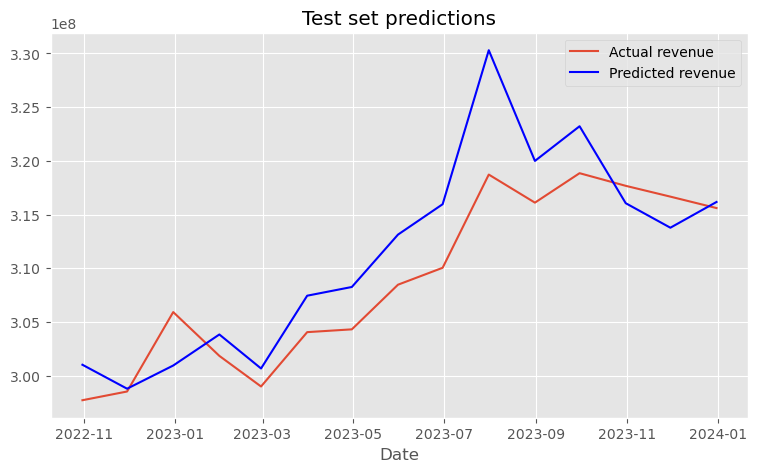

In [29]:
plt.figure(figsize=(9,5))
plt.plot(test, label='Actual revenue')
plt.plot(predictions, color='blue', label='Predicted revenue')
plt.title("Test set predictions")
plt.xlabel("Date")
plt.legend()
plt.show()